# Midterm Coding - Jan25

**Question 1)** ResNet on Cifar

**Question 2)** ResNet on small dataset

**Question 3)** Pretrained ResNet on small dataset

**Question 4)** Discussion

Please complete the code wherever you see "#Your code here"

Good luck!

## Question 1: ResNet on Cifar

#### 1. Prepare datasets 

In this part you need to:
- load images
- transform them to 3x224x224
- complete other necessary steps

In [25]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import datasets
import torchvision.utils as vutils
from torch.utils.data import TensorDataset
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [26]:
# Set device to GPU or CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Load image

In [27]:
# Your code here 
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True)

#### Transform image (augmentation)

In [8]:
# Your code here
train_preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

eval_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#### Other necessary steps

In [9]:
# Your code here
# Train test split + transform (recommend select few e.g. train 40000 val 10000
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
train_dataset.dataset = copy(full_train_dataset)
train_dataset.dataset.transform = train_preprocess
val_dataset.dataset.transform = eval_preprocess

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=eval_preprocess)

# DataLoaders for the three datasets (recommend bs = 128)
BATCH_SIZE=128
NUM_WORKERS=4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}


#### 2. Prepare model 

In this part you need to:
- complete the BottleneckBlock of ResNet
- create ResNet50 and ResNet101

## ResNet

On page 5 of [the ResNet paper](https://arxiv.org/pdf/1512.03385.pdf), the simplest ResNet
described is now known as ResNet18. It is a 1.8 GFLOP CNN with 8 residual blocks (two convolutional
layers in each residual block), which along with the initial convolution (7x7 in the paper, 3x3 here)
and the final linear / softmax layer gives us 18 layers:

<img src="img/ResNet18.JPG" title="ResNet18" style="width: 200px;" />

### Residual blocks

The residual block is a reusable block.
ResNet18 and ResNet34 use very basic residual blocks, but
ResNet50, ResNet101, and ResNet152 use more complicated residual blocks
with three convolutions, the middle of which is a
bottleneck that increases the representational power of the block
without an enormous increase in the number of parameters.

We need two types of residual block, one that preserves feature map size and one
that allows changes to the feature map size:

<img src="img/residualblock.png" title="Residual block" style="width: 640px;" />

Note that only the shape-preserving residual block has a real identity mapping.
The 1x1 strided convolution is the simplest way to allow changes in the input
feature map size, but since the parameters are learned, after training, the result
may be quite different from an identity mapping.

In [28]:
class BasicBlock(nn.Module):
    '''
    BasicBlock: Simple residual block with two conv layers
    '''
    EXPANSION = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

Here's the bottlneck version with three layers per residual block:

In [29]:
class BottleneckBlock(nn.Module):
    '''
    BottleneckBlock: More powerful residual block with three convs, used for Resnet50 and up
    '''
    # Your code here
    EXPANSION = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        # Your code here
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.EXPANSION * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.EXPANSION * planes)

        self.shortcut = nn.Sequential()
        # If the output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != self.EXPANSION * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.EXPANSION * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * planes)
            )

    def forward(self, x):
        # Your code here
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

### Resnet

Here is the whole shebang for ResNet, with the layer sizes tailored a bit to our input size of 64x64:

In [30]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Create ResNet50 and ResNet101

In [31]:
def ResNet18(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with two sets of two convolutions each: 2*2 + 2*2 + 2*2 + 2*2 = 16 conv layers
    last FC layer: 1
    Total layers: 1+16+1 = 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
    
def ResNet50(num_classes = 10):
    # Your code here
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of three convolutions each: 3*3 + 4*3 + 6*3 + 3*3 = 48
    last FC layer: 1
    Total layers: 1+48+1 = 50
    '''
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)
    
def ResNet101(num_classes = 10):
    # Your code here
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 23, 3] sets of three convolutions each: 3*3 + 4*3 + 23*3 + 3*3 = 99
    last FC layer: 1
    Total layers: 1+99+1 = 101
    '''
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)

### 3. Training

In this part, you need to:
- define necessary things for training
- train the model
- plot training loss and validation accuracy 

In [14]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model: train a model on a dataset
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # for process anything, device and dataset must put in the same place.
                # If the model is in GPU, input and output must set to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # it uses for update training weights
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        # print('outputs', outputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

Here we define the model, optimizer, loss function train the model

#1252 GB CUDA, Training took around 6-7 mins for me

In [15]:
# Your code here
# Model
resnet = ResNet18().to(device)

# Loss function
# Your code here
criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()

# Optimizer
# Your code here
optimizer = optim.Adam(params_to_update, lr=0.01)

# Train model
# Your code here
best_model, val_acc_history, loss_acc_history = train_model(resnet, dataloaders, criterion, optimizer, 25, 'resnet18_bestsofar')

Epoch 0/24
----------
train Loss: 1.8033 Acc: 0.3486
Epoch time taken:  13.957249402999878
val Loss: 1.5592 Acc: 0.4294
Epoch time taken:  15.249449729919434

Epoch 1/24
----------
train Loss: 1.2892 Acc: 0.5314
Epoch time taken:  13.32961368560791
val Loss: 1.3513 Acc: 0.5243
Epoch time taken:  14.613345384597778

Epoch 2/24
----------
train Loss: 0.9871 Acc: 0.6468
Epoch time taken:  13.441715240478516
val Loss: 0.9454 Acc: 0.6608
Epoch time taken:  14.735073328018188

Epoch 3/24
----------
train Loss: 0.7926 Acc: 0.7206
Epoch time taken:  13.49846887588501
val Loss: 0.8202 Acc: 0.7154
Epoch time taken:  14.815656185150146

Epoch 4/24
----------
train Loss: 0.6373 Acc: 0.7770
Epoch time taken:  13.516852378845215
val Loss: 0.6872 Acc: 0.7576
Epoch time taken:  14.899846076965332

Epoch 5/24
----------
train Loss: 0.5225 Acc: 0.8179
Epoch time taken:  13.543075561523438
val Loss: 0.5716 Acc: 0.8009
Epoch time taken:  14.886972665786743

Epoch 6/24
----------
train Loss: 0.4416 Acc: 0.

Please plot training loss and validation accuracy 

In [16]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history):
     # Your code here
    plt.plot(loss_acc_history, label = 'ResNet18')
    plt.title('Training loss over time')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'ResNet18')
    plt.title('Validation accuracy over time')
    plt.legend()
    plt.show()

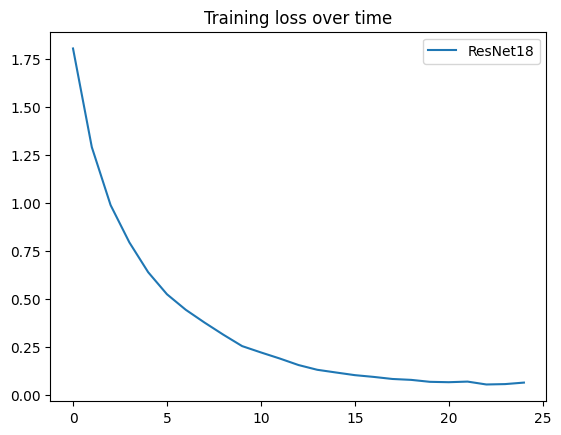

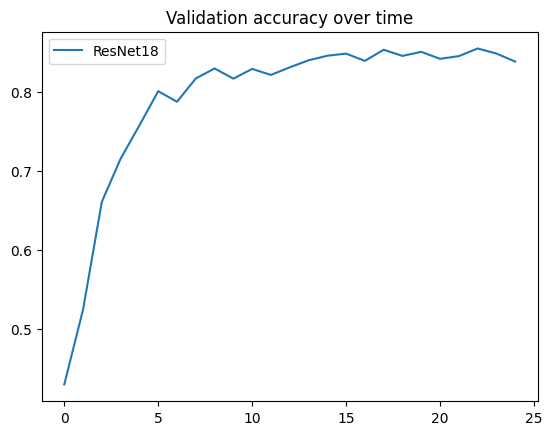

In [17]:
val_acc_history = [tensor.cpu() for tensor in val_acc_history]

plot_data(val_acc_history, loss_acc_history)

### 4. Evaluation

In this part, you need to:
- define necessary things for evaluating the trained model. This includes function that collects test loss and accuracy
- evaluate the model
- plot confusion matrix
- discuss the result

In [18]:
# Your code here
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
                
            loss = criterion(predictions, labels.long())
            
            predictions = nn.functional.softmax(predictions, dim=1)            
            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
                       
            predicteds.append(predicted)
            trues.append(labels)            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), predicteds, trues

In [19]:
resnet.load_state_dict(torch.load('resnet18_bestsofar.pth',))
test_loss, test_acc, test_pred_label, test_true_label  = evaluate(resnet, 
                                                                  test_dataloader, 
                                                                  criterion)
print('================== ResNet18 ======================')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

================== ResNet18 ======================
Test Loss: 0.691 | Test Acc: 84.41%


Now, let's take a closer look at the results. Please plot confusion matrix

#### Confusion Matrix

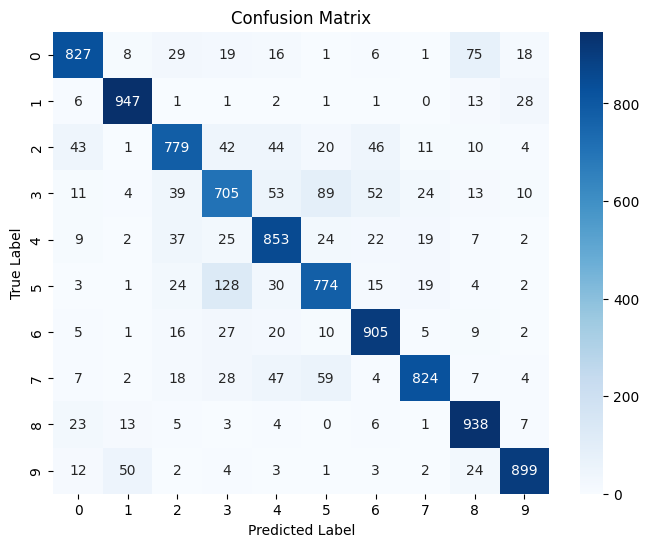

In [20]:
def plot_confusion_matrix(test_true_label_, test_pred_label_):
    cm = confusion_matrix(test_true_label_, test_pred_label_)
    
    
    # Plot heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Your code here
test_true_label_ = torch.cat(test_true_label).cpu().numpy()
test_pred_label_ = torch.cat(test_pred_label).cpu().numpy()
plot_confusion_matrix(test_true_label_, test_pred_label_)

Please discuss the result

In [21]:
# You discussion here







## Question 2: ResNet on small dataset

In this question, we will train ResNet18 on the Komondor vs. Mop dataset. 

#### Load data

In [32]:
dataset = datasets.ImageFolder(root='data-mop-dog',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
print(dataset.class_to_idx)

{'class_1': 0, 'class_2': 1}


### Training

In [33]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    print('====================== New Run =======================',file=open(f"{weights_name}.txt", "a"))

    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1), file=open(f"{weights_name}.txt", "a"))
        print('-' * 10, file=open(f"{weights_name}.txt", "a"))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)

                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), file=open(f"{weights_name}.txt", "a"))
            print(f"Epoch time taken: {elapsed_epoch}", file=open(f"{weights_name}.txt", "a"))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), file=open(f"{weights_name}.txt", "a"))
    print('Best val Acc: {:4f}'.format(best_acc), file=open(f"{weights_name}.txt", "a"))

    return  val_acc_history, loss_acc_history

#### 1. Perform training

In this part, you need to:
- perform K-fold cross validation to get a reasonable validation accuracy estimate since you only have few examples in each category. Each fold find the optimal hyperparameters. (select what you want to test + number of fold wisely. Make what ever assumption that is easy for you. e.g. 8 fold and you may want to find best optimizer param). **This part takes time! so don't choose too many folds!**
- plot validation loss and accuracy

In [34]:
import matplotlib.pyplot as plt

# Your code here
folds = 8
skf = StratifiedKFold(n_splits=folds, shuffle=True)

# Initialize storage for accuracy and loss plots
all_fold_acc = []
all_fold_loss = []

# Reset total accuracy
total_acc = 0

# Run 8-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(dataset, dataset.targets)):
    print(f'***** Fold {fold+1}/8 *****')

    # Create train and validation subsets
    train = torch.utils.data.Subset(dataset, train_index)
    val = torch.utils.data.Subset(dataset, val_index)

    # Data loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False, num_workers=0)

    # Train model on current fold
    model = ResNet18()
    model.linear = nn.Linear(512,2)
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer =  optim.Adam(model.parameters(), lr = 0.005)
    val_acc_history, loss_acc_history = train_model(model, {'train': train_loader, 'val': val_loader}, criterion, optimizer, 40, f'fold{fold}')

    # Convert accuracy history to numpy and compute final fold accuracy
    fold_acc = sum([tensor.cpu().item() for tensor in val_acc_history]) / len(val_acc_history)
    total_acc += fold_acc

    # Store fold-wise results for plotting
    all_fold_acc.append([tensor.cpu() for tensor in val_acc_history])
    all_fold_loss.append( [tensor for tensor in loss_acc_history])


    print(f'Fold {fold+1} Accuracy: {fold_acc:.4f}\n')

# Compute and print final average accuracy
avg_acc = total_acc / 8
print(f'Average 8-Fold Accuracy: {avg_acc:.4f}')

***** Fold 1/8 *****
Fold 1 Accuracy: 0.6312

***** Fold 2/8 *****
Fold 2 Accuracy: 0.6625

***** Fold 3/8 *****
Fold 3 Accuracy: 0.4875

***** Fold 4/8 *****
Fold 4 Accuracy: 0.5938

***** Fold 5/8 *****
Fold 5 Accuracy: 0.5813

***** Fold 6/8 *****
Fold 6 Accuracy: 0.6000

***** Fold 7/8 *****
Fold 7 Accuracy: 0.6813

***** Fold 8/8 *****
Fold 8 Accuracy: 0.5062

Average 8-Fold Accuracy: 0.5930


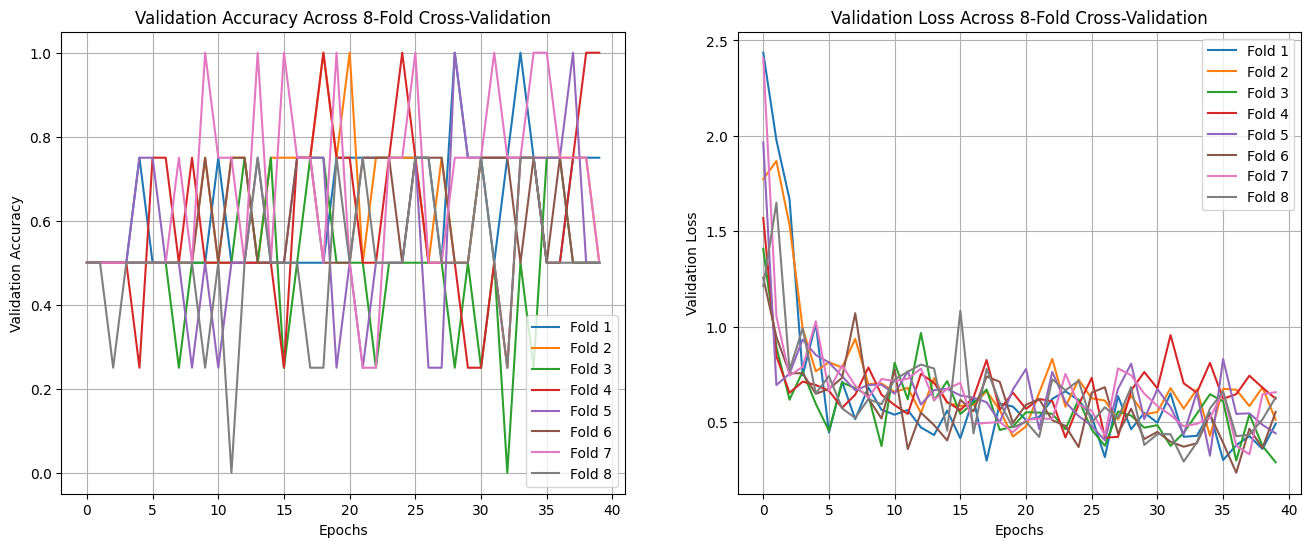

In [35]:
# Plot validation accuracy and loss across folds
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracy per epoch for each fold
for fold in range(8):
    ax[0].plot(np.arange(40), np.array(all_fold_acc[fold]), label=f"Fold {fold+1}")

ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Validation Accuracy")
ax[0].set_title("Validation Accuracy Across 8-Fold Cross-Validation")
ax[0].legend()
ax[0].grid(True)

# Plot loss per epoch for each fold
for fold in range(8):
    ax[1].plot(np.arange(40), np.array(all_fold_loss[fold]), label=f"Fold {fold+1}")

ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Validation Loss")
ax[1].set_title("Validation Loss Across 8-Fold Cross-Validation")
ax[1].legend()
ax[1].grid(True)

# Show plots
plt.show()


#### 2. Evaluation
- Evaluate the model on the test samples (in data-mop-dog-test folder).
- This includes confusion metric and displaying image along with the predicted label and its ground truth
- Interpret the result

In [36]:
dataset_test = datasets.ImageFolder(root='data-mop-dog-test',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
test_dataloader = torch.utils.data.DataLoader(dataset_test,batch_size = 1,shuffle = True)

In [37]:
def evaluate(model, iterator, criterion, class_names):
    # Your code here
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
        for batch, labels in iterator:
            
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels.long())

            predictions = nn.functional.softmax(predictions, dim=1)
            _, predicted = torch.max(predictions.data, 1)

            predicteds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc

            # Display some sample images with predictions
            show_images(batch.cpu(), predicted.cpu(), labels.cpu(), class_names)

    # Compute and display confusion matrix
    plot_confusion_matrix(trues, predicteds, class_names)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predicteds, trues


In [38]:

def show_images(images, predicted_labels, true_labels, class_names):
    """
    Displays images with predicted and true labels.
    """
    images = torchvision.utils.make_grid(images, nrow=8)  # Arrange images in a grid
    images = images.numpy().transpose((1, 2, 0))  # Convert to (H, W, C) format

    # Normalize back to [0,1] if images were normalized
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean  # Unnormalize
    images = np.clip(images, 0, 1)  # Clip values

    plt.figure(figsize=(12, 6))
    plt.imshow(images)
    plt.axis("off")
    plt.title("Predictions: " + " | ".join([f"{class_names[p]} (True: {class_names[t]})"
                                            for p, t in zip(predicted_labels, true_labels)]))
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

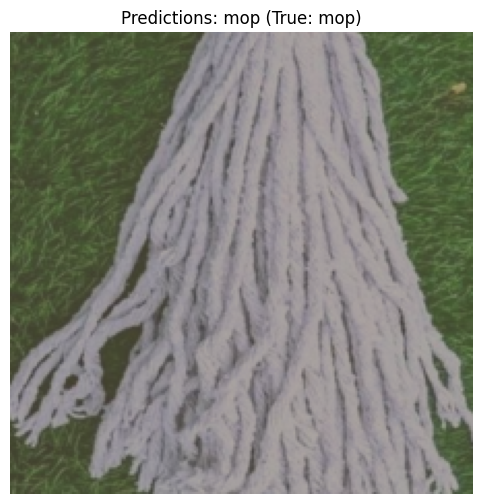

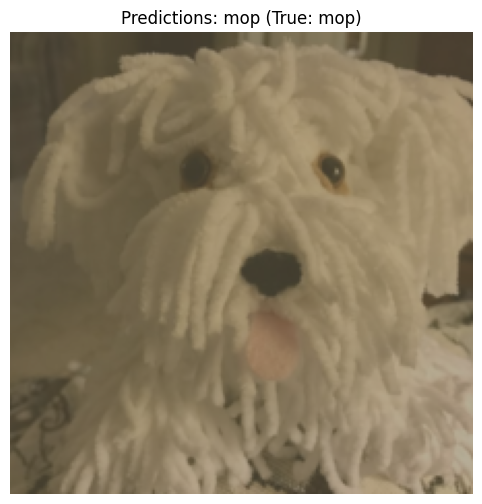

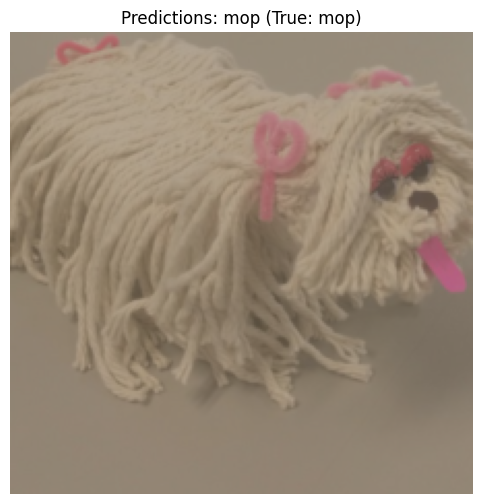

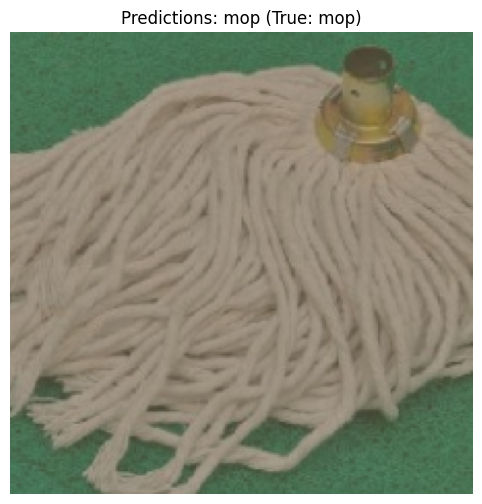

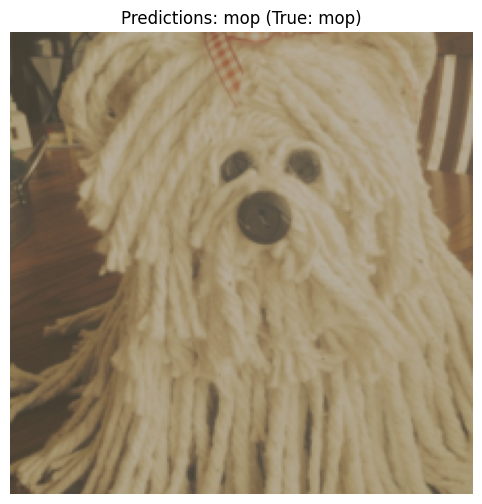

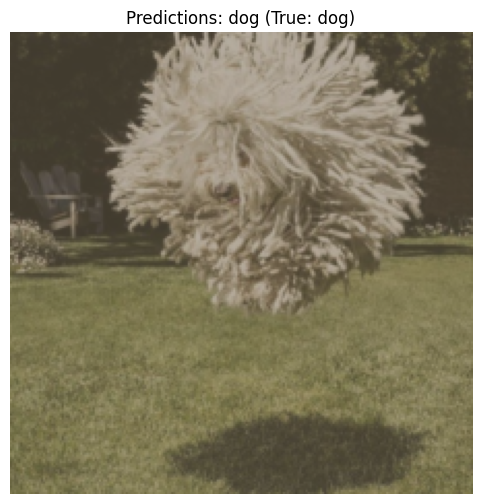

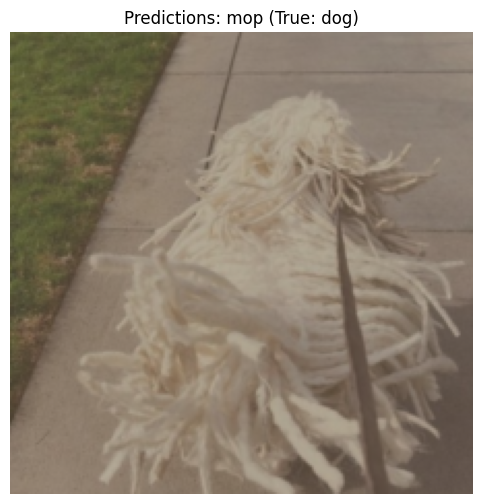

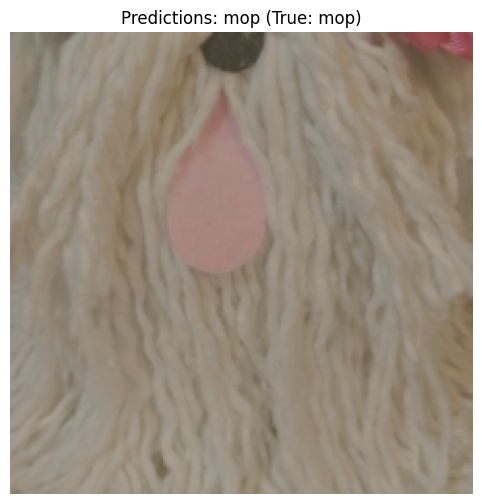

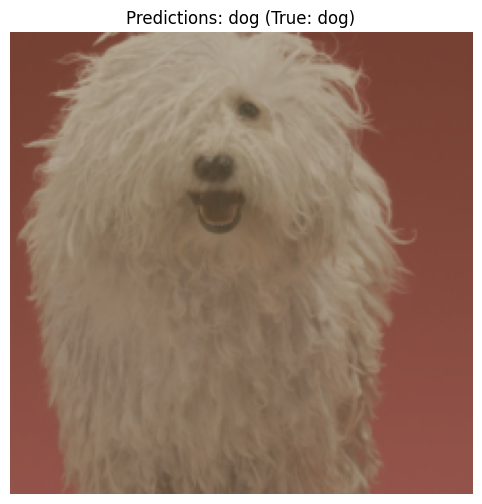

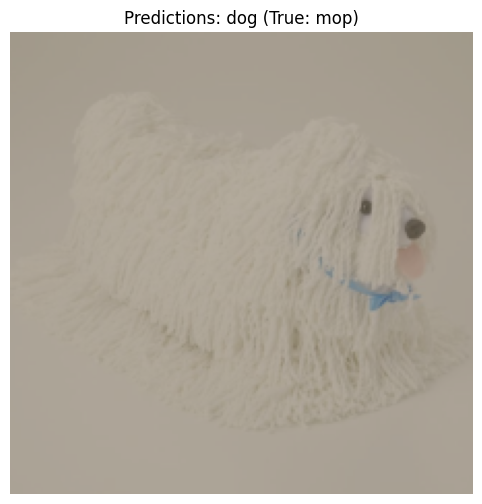

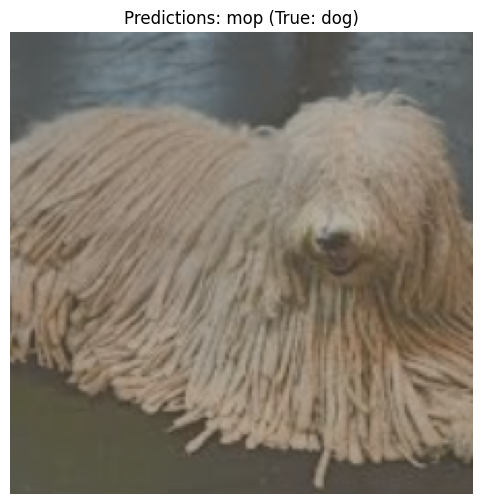

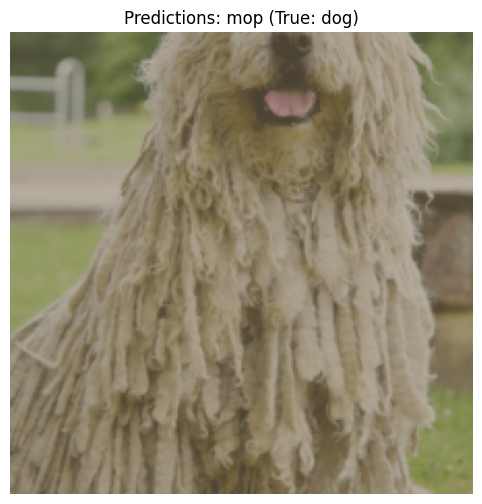

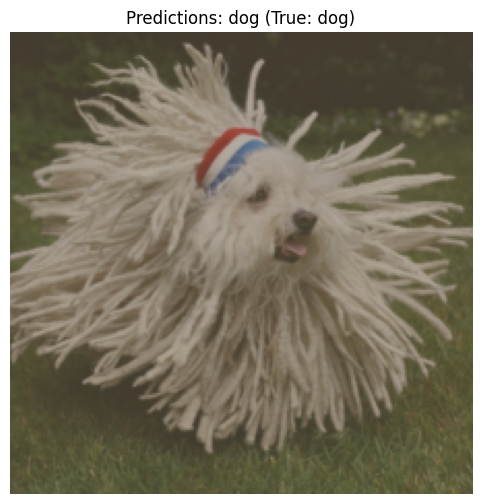

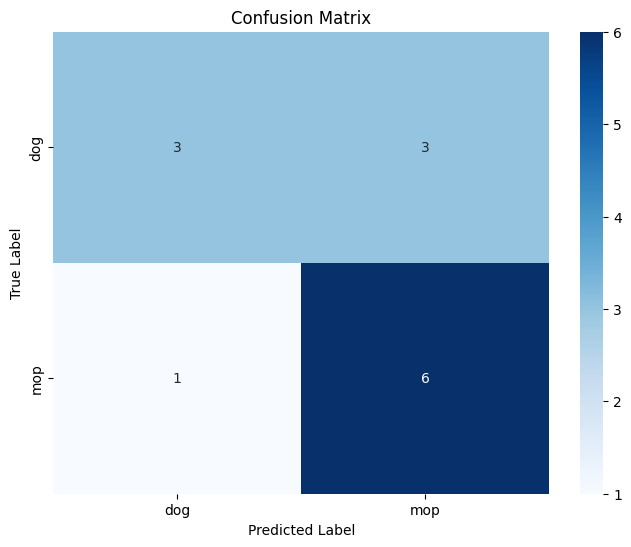

In [39]:
# Your code here 
model_test = ResNet18()
model_test.linear = nn.Linear(512,2)
model_test.eval()
model_test.to(device)
model_test.load_state_dict(torch.load(f'fold4.pth'))
criterion = nn.CrossEntropyLoss()

class_names = ["dog", "mop"]


test_loss, test_acc, test_pred_label, test_true_label  = evaluate(model_test, test_dataloader, criterion, class_names)

In [40]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 1.134 | Test Acc: 88.52%


## Question 3) Pretrained ResNet18 on small dataset

In this question, we will train pretrained ResNet18 on the Komondor vs. Mop dataset. 

In [41]:
import torch
import torchvision.models as models

In [42]:
# Your code here
folds = 8
skf = StratifiedKFold(n_splits=folds, shuffle=True)

# Initialize storage for accuracy and loss plots
all_fold_acc = []
all_fold_loss = []

# Reset total accuracy
total_acc = 0

# Run 8-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(dataset, dataset.targets)):
    print(f'***** Fold {fold+1}/8 *****')

    # Create train and validation subsets
    train = torch.utils.data.Subset(dataset, train_index)
    val = torch.utils.data.Subset(dataset, val_index)

    # Data loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False, num_workers=0)

    # Train model on current fold
    model = models.resnet18(pretrained=True)  # Set False if you don't want pre-trained weights
    model.linear = nn.Linear(512,2)
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer =  optim.Adam(model.parameters(), lr = 0.005)
    val_acc_history, loss_acc_history = train_model(model, {'train': train_loader, 'val': val_loader}, criterion, optimizer, 40, f'resnet_pretrained_fold{fold}')

    # Convert accuracy history to numpy and compute final fold accuracy
    fold_acc = sum([tensor.cpu().item() for tensor in val_acc_history]) / len(val_acc_history)
    total_acc += fold_acc

    # Store fold-wise results for plotting
    all_fold_acc.append([tensor.cpu() for tensor in val_acc_history])
    all_fold_loss.append( [tensor for tensor in loss_acc_history])

    # all_fold_acc.append(val_acc_history)
    # all_fold_loss.append(loss_acc_history.cpu())

    print(f'Fold {fold+1} Accuracy: {fold_acc:.4f}\n')

# Compute and print final average accuracy
avg_acc = total_acc / 8
print(f'Average 8-Fold Accuracy: {avg_acc:.4f}')

***** Fold 1/8 *****


/home/jupyter-rtml01/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-rtml01/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jupyter-rtml01/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.1MB/s]


Fold 1 Accuracy: 0.5000

***** Fold 2/8 *****
Fold 2 Accuracy: 0.6500

***** Fold 3/8 *****
Fold 3 Accuracy: 0.4562

***** Fold 4/8 *****
Fold 4 Accuracy: 0.6937

***** Fold 5/8 *****
Fold 5 Accuracy: 0.5938

***** Fold 6/8 *****
Fold 6 Accuracy: 0.5250

***** Fold 7/8 *****
Fold 7 Accuracy: 0.7375

***** Fold 8/8 *****
Fold 8 Accuracy: 0.6937

Average 8-Fold Accuracy: 0.6062


#### 2. Evaluation
- Evaluate the model on the test samples (in data-mop-dog-test folder).
- This includes confusion metric and displaying image along with the predicted label and its ground truth
- Interpret the result

In [43]:
dataset_test = datasets.ImageFolder(root='data-mop-dog-test',
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
test_dataloader = torch.utils.data.DataLoader(dataset_test,batch_size = 1,shuffle = True)

In [44]:
def evaluate(model, iterator, criterion, class_names):
    # Your code here
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
        for batch, labels in iterator:
            
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels.long())

            predictions = nn.functional.softmax(predictions, dim=1)
            _, predicted = torch.max(predictions.data, 1)

            predicteds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc

            # Display some sample images with predictions
            show_images(batch.cpu(), predicted.cpu(), labels.cpu(), class_names)

    # Compute and display confusion matrix
    plot_confusion_matrix(trues, predicteds, class_names)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), predicteds, trues


In [45]:

def show_images(images, predicted_labels, true_labels, class_names):
    """
    Displays images with predicted and true labels.
    """
    images = torchvision.utils.make_grid(images, nrow=8)  # Arrange images in a grid
    images = images.numpy().transpose((1, 2, 0))  # Convert to (H, W, C) format

    # Normalize back to [0,1] if images were normalized
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean  # Unnormalize
    images = np.clip(images, 0, 1)  # Clip values

    plt.figure(figsize=(12, 6))
    plt.imshow(images)
    plt.axis("off")
    plt.title("Predictions: " + " | ".join([f"{class_names[p]} (True: {class_names[t]})"
                                            for p, t in zip(predicted_labels, true_labels)]))
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

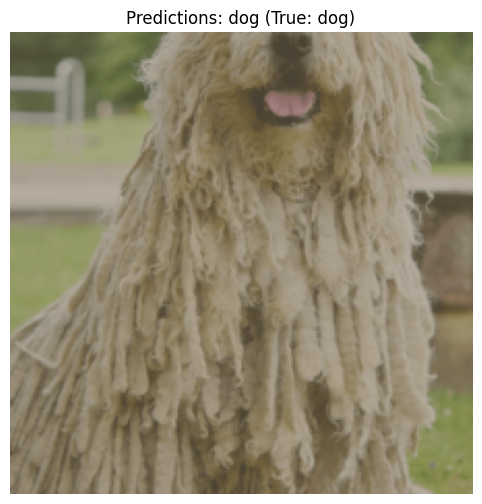

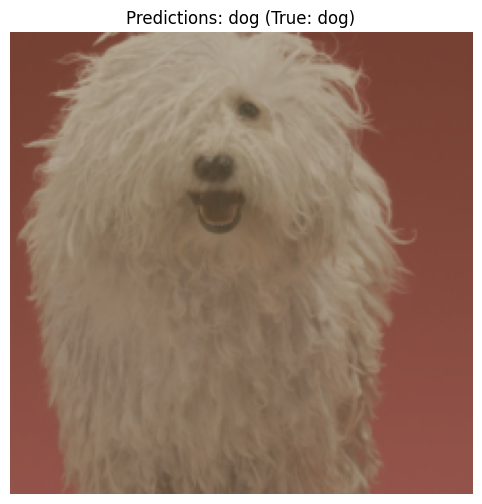

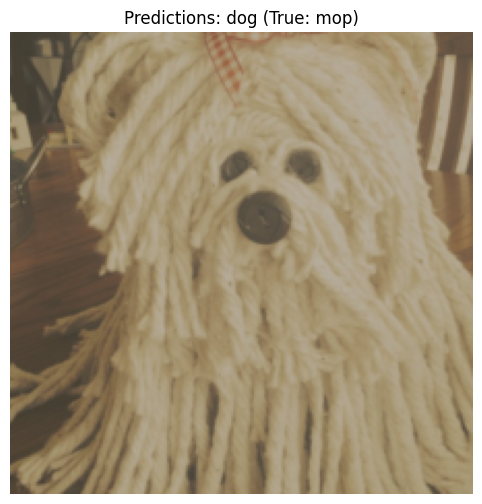

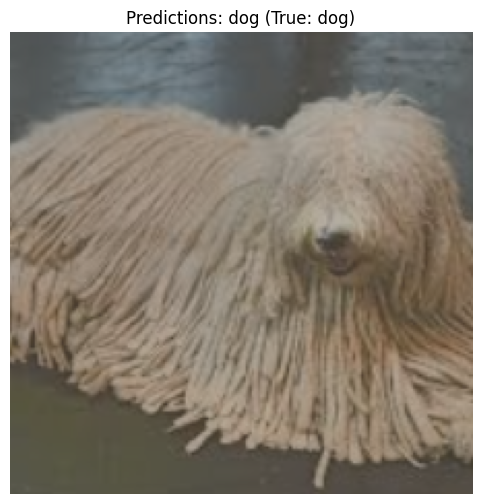

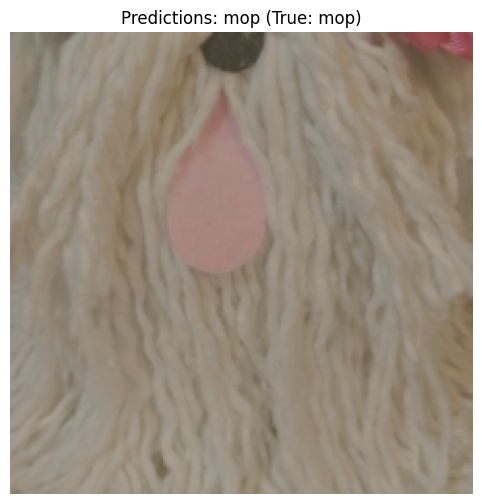

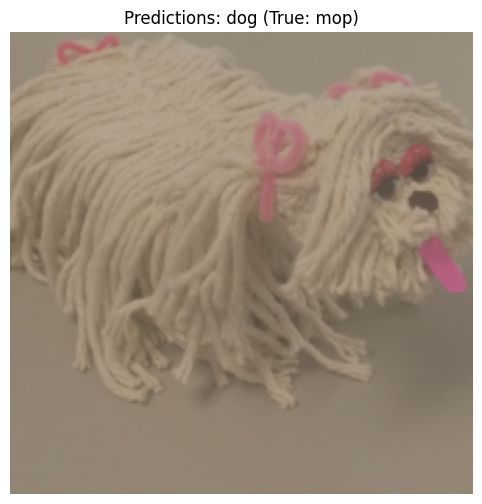

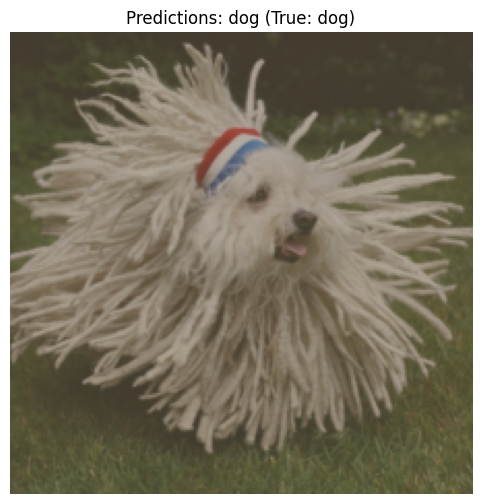

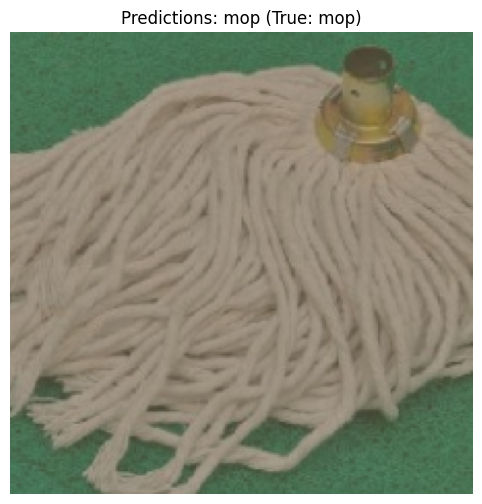

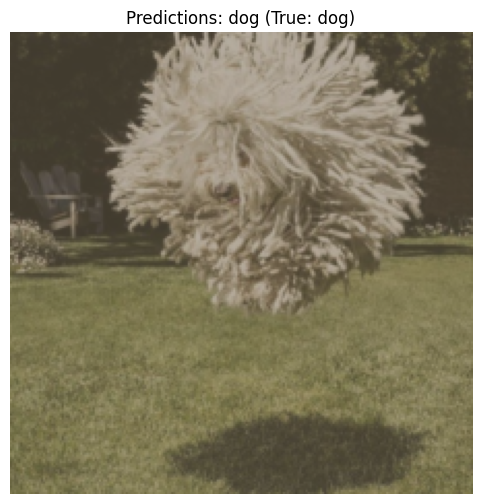

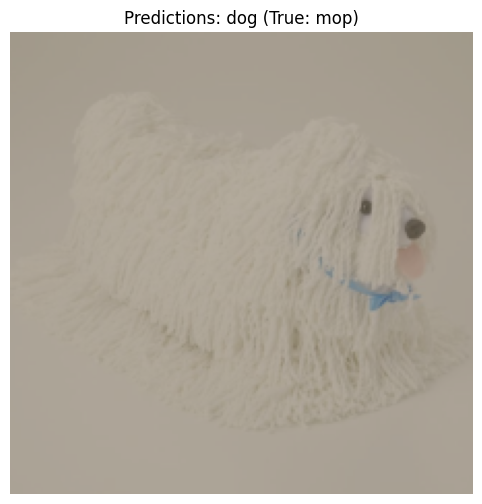

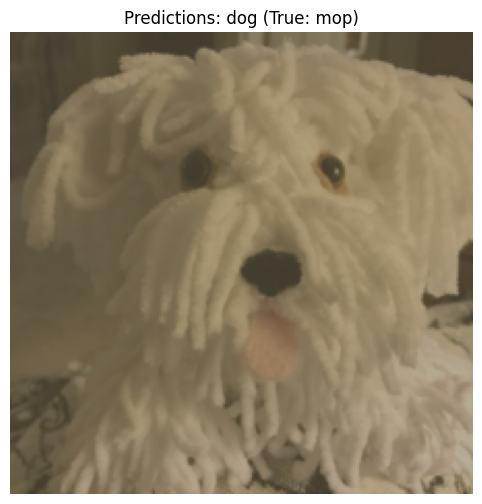

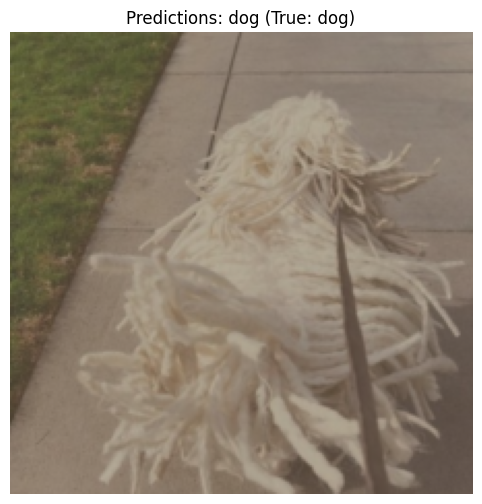

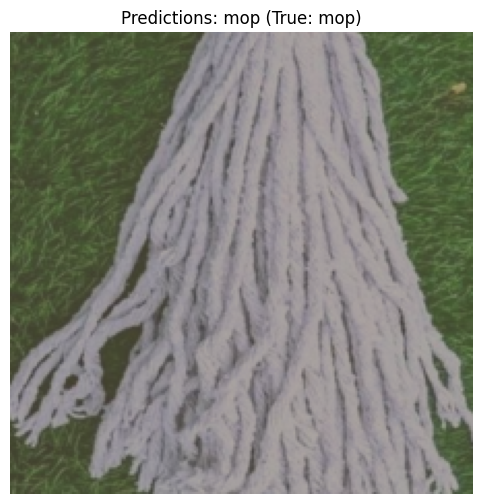

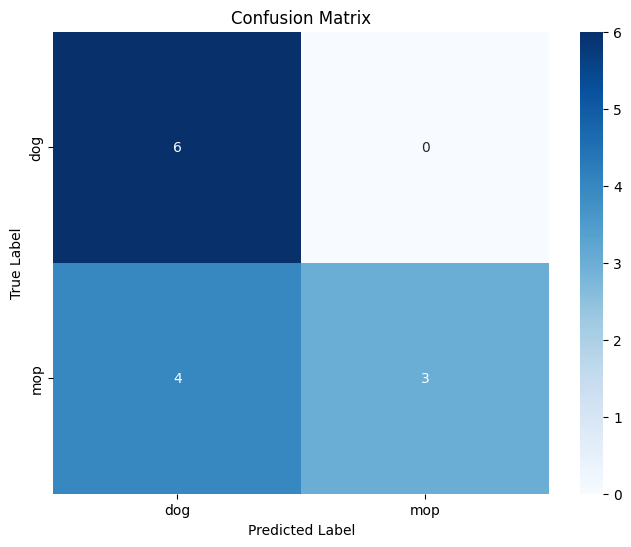

In [46]:
# Your code here 
model_test = models.resnet18()
model_test.linear = nn.Linear(512,2)
model_test.eval()
model_test.to(device)
model_test.load_state_dict(torch.load(f'resnet_pretrained_fold6.pth'))
criterion = nn.CrossEntropyLoss()

class_names = ["dog", "mop"]


test_loss, test_acc, test_pred_label, test_true_label  = evaluate(model_test, test_dataloader, criterion, class_names)

In [47]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 0.844 | Test Acc: 75.54%


## Question 4: Discuss the results
You may include:
- describe the results
- why is it like this what are the possible reasons
- how would you improve it?